In [5]:
import os
import random
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
from lightly.data import (
    LightlyDataset,
    collate,
)
import pickle
from scipy.spatial.distance import cdist
from sklearn import neighbors
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer

from swav_cifar import SwaVModel
from train import DIR_ROOT_SAVE
from utils import PATH_DATASETS

warnings.filterwarnings("ignore", category=UserWarning)
sns.set(font_scale=1.2)

NUM_TRAIN = 50000
NUM_TEST = 10000
NUM_FEATURES = 512
BATCH_SIZE = 512
NUM_CLASSES = 10
path_to_train = os.path.join(PATH_DATASETS, 'cifar10images', 'train')
path_to_test = os.path.join(PATH_DATASETS, 'cifar10images', 'test')

# No additional augmentations for the test set
test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=collate.imagenet_normalize["mean"],
            std=collate.imagenet_normalize["std"],
        ),
    ]
)

dataset_train_ssl = LightlyDataset(input_dir=path_to_train)
# we use test transformations for getting the feature for kNN on train data
dataset_train_kNN = LightlyDataset(input_dir=path_to_train, transform=test_transforms)
dataset_test = LightlyDataset(input_dir=path_to_test, transform=test_transforms)

dataloader_train_kNN = torch.utils.data.DataLoader(dataset_train_kNN, batch_size=BATCH_SIZE, shuffle=False,
                                                   drop_last=False, num_workers=4)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                                              num_workers=4)

PATH_MODEL = os.path.join(DIR_ROOT_SAVE, f'swav_cifar10_{NUM_FEATURES}')
swav = SwaVModel(dataloader_train_kNN, NUM_CLASSES)
swav.load_state_dict(torch.load(os.path.join(PATH_MODEL, 'model.pt'))['model'])
swav.eval()

features = np.load(os.path.join(PATH_MODEL, 'feature.npy'))
labels = np.load(os.path.join(PATH_MODEL, 'labels.npy'))
# features_test = np.load(os.path.join(PATH_MODEL, 'features_test.npy'))
# labels_test = np.load(os.path.join(PATH_MODEL, 'labels_test.npy'))

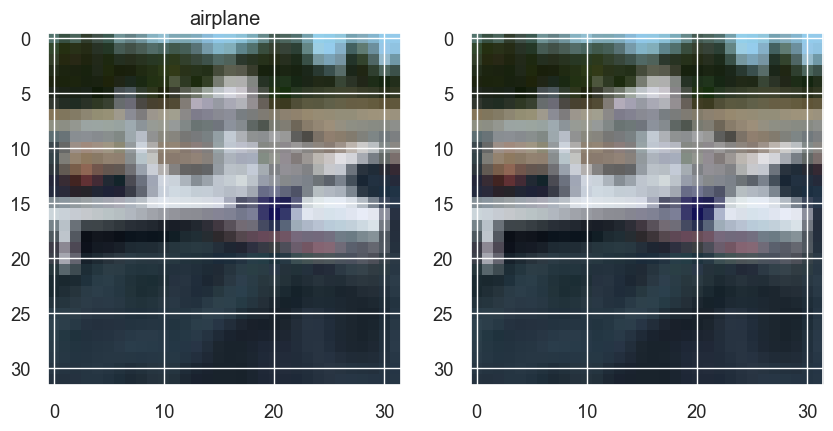

In [6]:
data1 = torchvision.datasets.CIFAR10(PATH_DATASETS, train=True, download=False)
CLASSES = data1.classes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
i = random.randint(0, NUM_TEST)
img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
axes[0].set_title(CLASSES[dataset_train_ssl[i][1]])
axes[0].imshow(data1[img_idx][0])
axes[1].imshow(dataset_train_ssl[i][0])
for i in range(NUM_TRAIN):
    img_idx = int(re.findall(r'\d+', dataset_train_ssl[i][2])[-1])
    assert dataset_train_ssl[i][0] == data1[img_idx][0], i

In [12]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=True).fit_transform(
    features)

df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = X_embedded[:, 0]
df["comp-2"] = X_embedded[:, 1]
df.to_csv(os.path.join(PATH_MODEL, 'tsne.csv'))

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.029s...
[t-SNE] Computed neighbors for 50000 samples in 10.796s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

[Text(0.5, 1.0, 'CIFAR10 dataset T-SNE projection')]

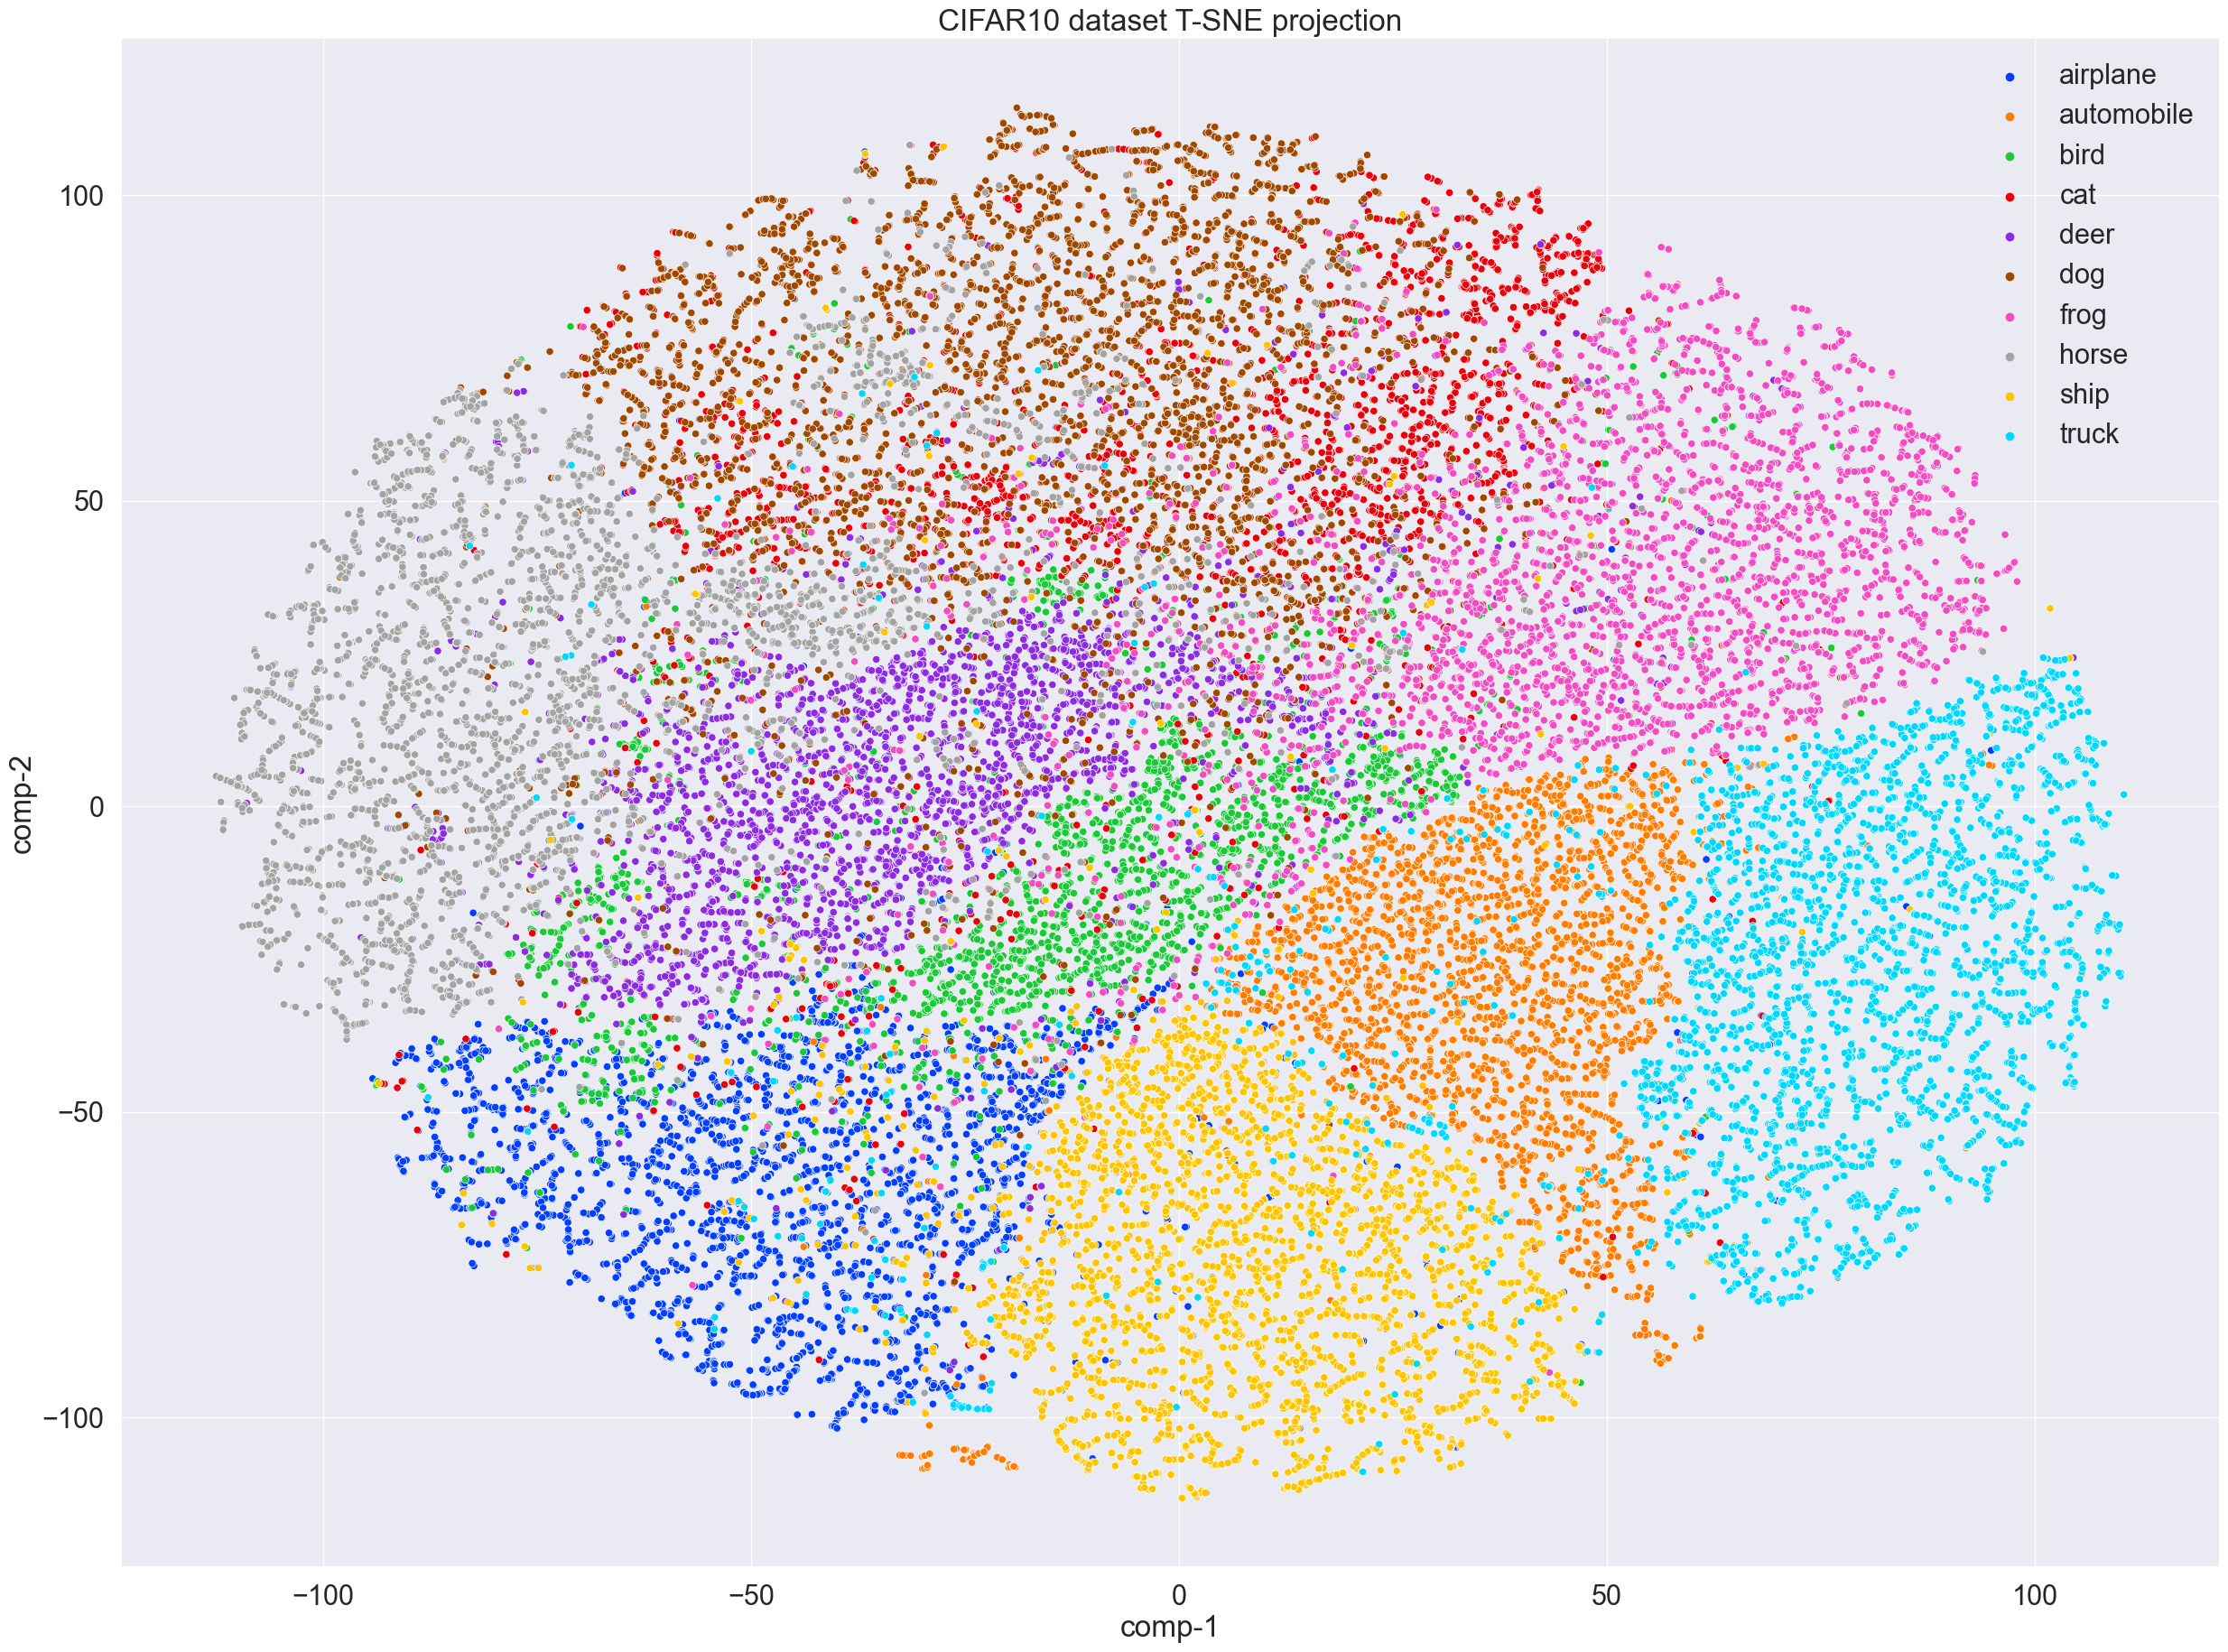

In [7]:
df = pd.read_csv(os.path.join(PATH_MODEL, 'tsne.csv'))
sns.set(rc={'figure.figsize': (30, 22)}, font_scale=2)
sns.scatterplot(x="comp-1", y="comp-2", hue=np.array(CLASSES)[df.y.values],
                palette=sns.color_palette("bright", 10),
                data=df).set(title="CIFAR10 dataset T-SNE projection")

In [35]:
print(df.y.values.dtype)
np.array(CLASSES)[df.y.values]

int64


array(['airplane', 'airplane', 'airplane', ..., 'truck', 'truck', 'truck'],
      dtype='<U10')

In [3]:
clf = neighbors.KNeighborsClassifier(n_neighbors=200)
clf.fit(features, labels)
p = clf.predict(features)
sum(np.equal(p, labels)) / NUM_TRAIN

0.83362

In [2]:
features_test = np.empty((NUM_TEST, NUM_FEATURES))
labels_test = np.empty((NUM_TEST,), dtype=int)

n = 0
for images, label, files_names in dataloader_test:
    features_test[n:n + len(label)] = swav(images).detach().numpy()
    labels_test[n:(n := n + len(label))] = np.array(label)

sum(np.equal(clf.predict(features_test), labels_test)) / NUM_TEST
np.save(os.path.join(PATH_MODEL, 'features_test.npy'), features_test)
np.save(os.path.join(PATH_MODEL, 'labels_test.npy'), labels_test)

NameError: name 'clf' is not defined

In [7]:
idx = np.empty(NUM_TRAIN, dtype=int)
for i, img_data in enumerate(dataset_train_ssl):
    idx[int(re.findall(r'\d+', img_data[2])[-1])] = i
np.save(os.path.join(PATH_MODEL, 'idx.npy'), idx)

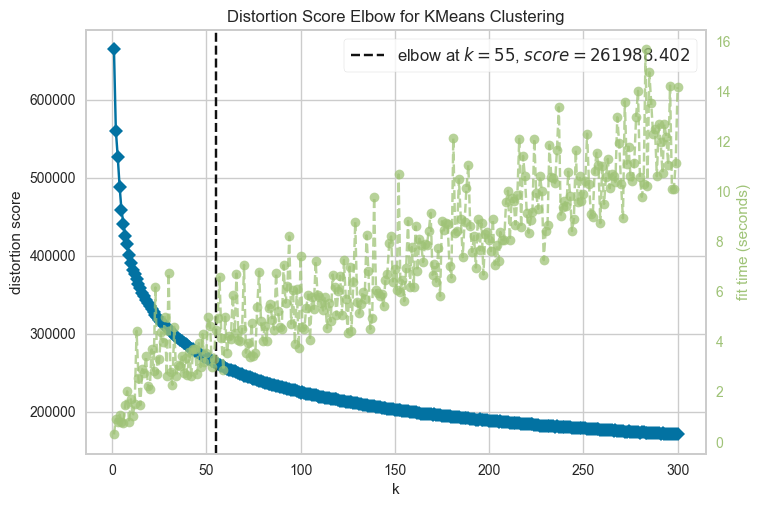

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [92]:
km = KMeans(max_iter=100000, n_init="auto", verbose=True)
visualizer = KElbowVisualizer(km, k=(1, 301))

visualizer.fit(features)  # Fit the data to the visualizer
visualizer.show()

In [24]:
k = 55
model_k_55 = KMeans(n_clusters=k, n_init=10, max_iter=100000, verbose=True).fit(features)
pred_55 = model_k_55.predict(features)
m2_55 = model_k_55.transform(features)
km_dist = m2_55[np.arange(NUM_TRAIN), pred_55][idx]
np.save(os.path.join(PATH_MODEL, 'km_dist.npy'), km_dist)

Initialization complete
Iteration 0, inertia 392141.8229316379.
Iteration 1, inertia 279053.0683598094.
Iteration 2, inertia 273393.88698932715.
Iteration 3, inertia 270871.1940606901.
Iteration 4, inertia 269502.55084832327.
Iteration 5, inertia 268642.99383538077.
Iteration 6, inertia 268023.01392290636.
Iteration 7, inertia 267500.55010832875.
Iteration 8, inertia 267038.9460447973.
Iteration 9, inertia 266647.60556278325.
Iteration 10, inertia 266319.28690551664.
Iteration 11, inertia 265999.0105114085.
Iteration 12, inertia 265635.01360086066.
Iteration 13, inertia 265254.04640004935.
Iteration 14, inertia 264909.15736576996.
Iteration 15, inertia 264615.17357549374.
Iteration 16, inertia 264342.1580769138.
Iteration 17, inertia 264103.11910794955.
Iteration 18, inertia 263903.2993966629.
Iteration 19, inertia 263713.5872994664.
Iteration 20, inertia 263549.99762551085.
Iteration 21, inertia 263403.65661940153.
Iteration 22, inertia 263272.51404804515.
Iteration 23, inertia 263169

In [25]:
PATH_EL2N = os.path.join(DIR_ROOT_SAVE, 'el2n_resnet18_cifar10', 'general.pt')
PATH_FORGET = os.path.join(DIR_ROOT_SAVE, 'flip_cifar10', 'model', 'other.pt')

# get prune scores
data = torch.load(PATH_EL2N)

ensemble_softmax = data['ensemble_softmax']
ensemble_pred = data['ensemble_pred']
ensemble_pred_sum = data['ensemble_pred_sum']
ensemble_std = data['ensemble_std']
el2n_scores = data['el2n_scores']
change_counter = torch.load(PATH_FORGET)['change_counter']
true_forget = torch.load(PATH_FORGET)['true_forget']
km_55 = np.load(os.path.join(PATH_MODEL, 'km_dist.npy'))

idx_sorted_el2n = el2n_scores.sort()[1].numpy()
idx_sorted_forgetting = change_counter.sort()[1].numpy()
idx_sorted_std = ensemble_std.sum(dim=1).sort()[1].numpy()
idx_sorted_pred_sum = ensemble_pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = true_forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)
idx_sorted_km_55 = np.argsort(km_55)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_forgetting, 'forget': idx_true_forget,
              'km': idx_sorted_km_55}

data = pd.DataFrame({
    'EL2N': el2n_scores.numpy(),
    'Std': ensemble_std.sum(dim=1).numpy(),
    'True p sum': ensemble_pred_sum.numpy(),  # number of models that right on each example
    'flip': change_counter.numpy(),
    'forget': true_forget.numpy(),
    'km': km_55
})
data.corr()

EL2N       Std  True p sum      flip    forget        km
EL2N        1.000000  0.780107   -0.944299  0.658627  0.399751  0.529046
Std         0.780107  1.000000   -0.660269  0.586532  0.377763  0.496631
True p sum -0.944299 -0.660269    1.000000 -0.627331 -0.350162 -0.460980
flip        0.658627  0.586532   -0.627331  1.000000  0.770378  0.394874
forget      0.399751  0.377763   -0.350162  0.770378  1.000000  0.253914
km          0.529046  0.496631   -0.460980  0.394874  0.253914  1.000000

In [133]:
distortions = {}
inertias = {}
k_val = {}
K = range(1, 301)
for k in K:
    # Building and fitting the model
    print(f'------------   k={k}   --------------------------')
    kMeanModel = KMeans(n_clusters=k, max_iter=100000, n_init="auto", verbose=False).fit(features)

    pred = kMeanModel.predict(features)
    m2 = kMeanModel.transform(features)
    dist_ = m2[np.arange(NUM_TRAIN), pred]
    k_val[k] = dist_

    # i = random.randint(0, 50000)
    # print((np.sum(((features[i] - kMeanModel.cluster_centers_[pred[i]]) ** 2))) ** .5)
    # print(m2[i][pred[i]], dist_[i])

    dist = np.min(cdist(features, kMeanModel.cluster_centers_, 'euclidean'), axis=1)
    # print(dist[:2],dist_[:2])
    distortions[k] = np.average(dist)
    inertias[k] = kMeanModel.inertia_

with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'wb') as f:
    pickle.dump([k_val, distortions, inertias], f)

------------   k=1   --------------------------
------------   k=2   --------------------------
------------   k=3   --------------------------
------------   k=4   --------------------------
------------   k=5   --------------------------
------------   k=6   --------------------------
------------   k=7   --------------------------
------------   k=8   --------------------------
------------   k=9   --------------------------
------------   k=10   --------------------------
------------   k=11   --------------------------
------------   k=12   --------------------------
------------   k=13   --------------------------
------------   k=14   --------------------------
------------   k=15   --------------------------
------------   k=16   --------------------------
------------   k=17   --------------------------
------------   k=18   --------------------------
------------   k=19   --------------------------
------------   k=20   --------------------------
------------   k=21   -------

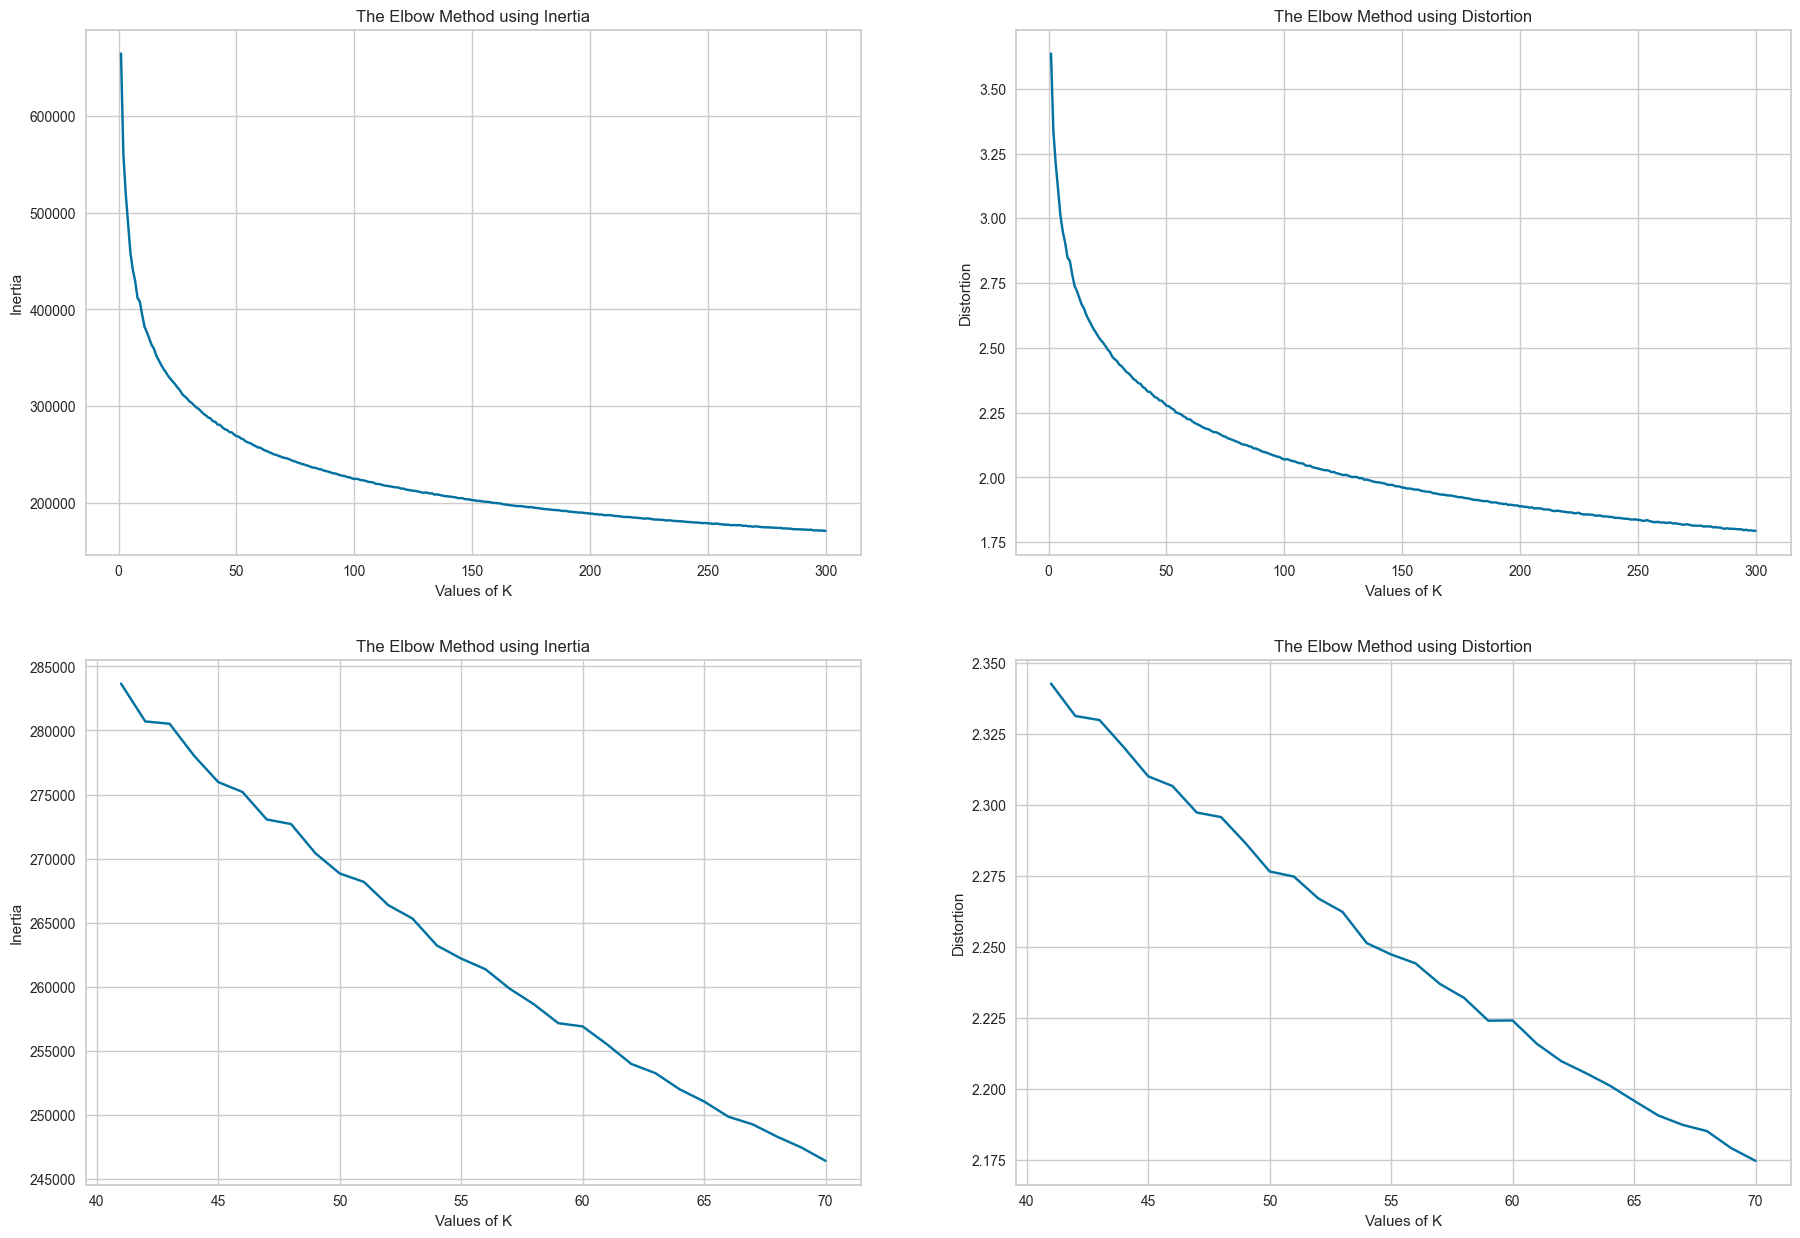

In [23]:
with open(os.path.join(PATH_MODEL, 'all_k_1_300.npy'), 'rb') as f:
    k_val, distortions, inertias = pickle.load(f)

plt.figure(figsize=(22, 15))
plt.subplot(2, 2, 1)
plt.plot([k for k in inertias.keys()], [k for k in inertias.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 2)
plt.plot([k for k in distortions.keys()], [k for k in distortions.values()], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')

i, j = 40, 70
plt.subplot(2, 2, 3)
plt.plot([k for k in inertias.keys()][i:j], [k for k in inertias.values()][i:j], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')

plt.subplot(2, 2, 4)
plt.plot([k for k in distortions.keys()][i:j], [k for k in distortions.values()][i:j], 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

clf = OneVsRestClassifier(SVC(), verbose=True).fit(features, labels)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [ ]:
clf.score(features, labels), clf.score(features_test, labels_test)

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader


class Data(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(np.array(x, dtype=np.float32)).cuda()
        self.y = torch.from_numpy(np.array(y, dtype=int)).type(torch.cuda.LongTensor)
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len


loader_train = torch.utils.data.DataLoader(Data(features, labels), batch_size=25, shuffle=True)
loader_test = torch.utils.data.DataLoader(Data(features_test, labels_test), batch_size=25, shuffle=False)


class MultiOutputRegression(torch.nn.Module):
    def __init__(self):
        super(MultiOutputRegression, self).__init__()
        self.linear1 = torch.nn.Linear(512, 1024)
        self.linear2 = torch.nn.Linear(1024, 256)
        # self.linear3 = torch.nn.Linear(128, 128)
        self.linear4 = torch.nn.Linear(256, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        # x = self.linear3(x)
        x = self.linear4(x)
        return x


model = MultiOutputRegression()
model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_train, loss_test = [], []
acc_train, acc_test = [], []

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

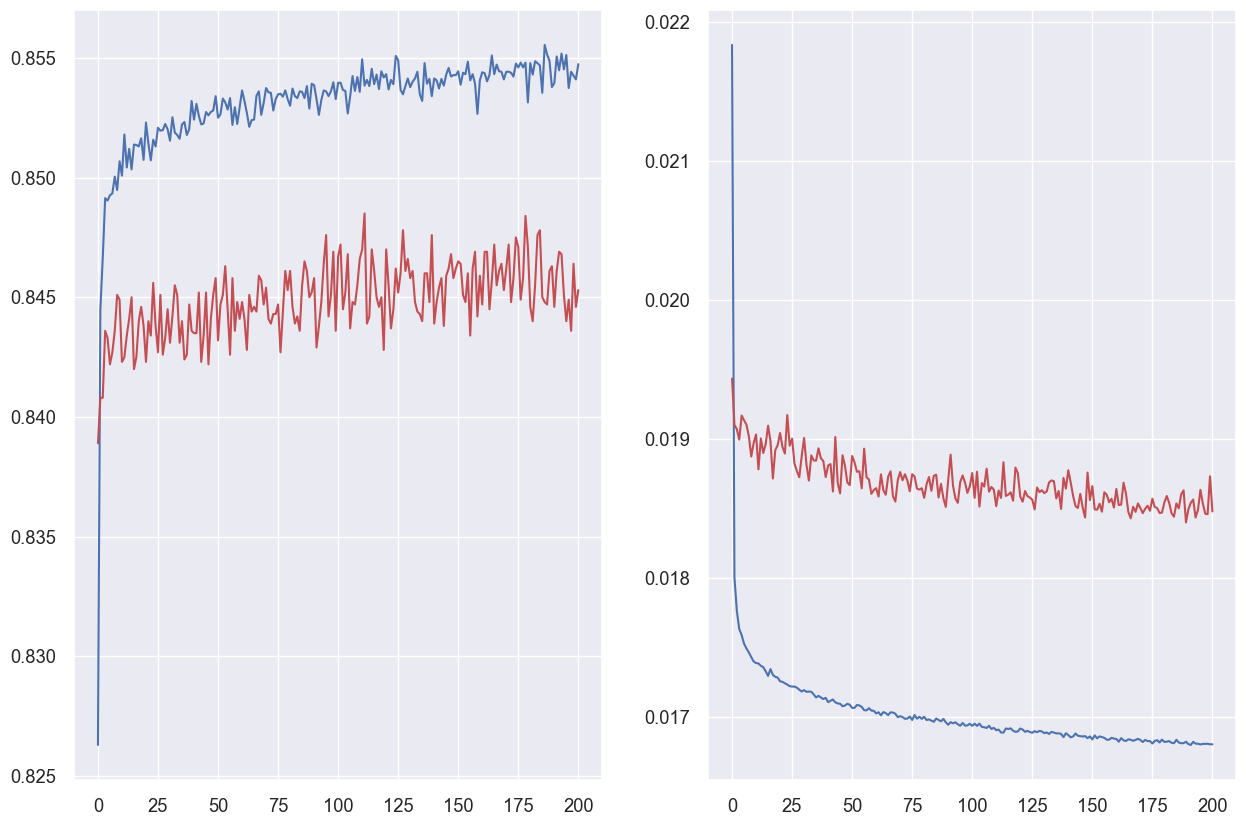

In [16]:
for epoch in range(200):
    print(epoch, end=' ')
    model.train()
    l, acc = 0., 0.
    for x, y in loader_train:
        optimizer.zero_grad()
        p = model(x)
        loss = criterion(p, y)
        loss.backward()
        optimizer.step()
        l += loss.detach().item()
        acc += torch.sum(torch.max(p, 1)[1].eq(y)).item()
    loss_train.append(l / NUM_TRAIN)
    acc_train.append(acc / NUM_TRAIN)

    model.eval()
    l, acc = 0., 0.
    for x, y in loader_test:
        p = model(x)
        loss = criterion(p, y)
        l += loss.detach().item()
        acc += torch.sum(torch.max(p, 1)[1].eq(y)).item()
    loss_test.append(l / NUM_TEST)
    acc_test.append(acc / NUM_TEST)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].plot(range(len(acc_train)), acc_train, c='b')
axes[0].plot(range(len(acc_test)), acc_test, c='r')
axes[1].plot(range(len(loss_train[:])), loss_train[:], c='b')
axes[1].plot(range(len(loss_test[:])), loss_test[:], c='r')